<a href="https://colab.research.google.com/github/mondjisola/dpro_divic/blob/master/Housing_Price_Forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data reading and feature selection

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1W1fq62amvtOiCRiH1-hnH74Xx9SOuPMC'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')

In [ ]:
# Load the dataset
data = pd.read_csv('train.csv')

# Select the relevant features
features = data[['GrLivArea', 'YearBuilt']]
target = data['SalePrice']

# Estimation and evaluation by linear regression

## Data preprocessing

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Checking for missing values
print(features.isnull().sum())

# If there are missing values, we'll fill them with the median of the column
features = features.fillna(features.median())

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

GrLivArea    0
YearBuilt    0
dtype: int64


## Training, estimation, evaluation

In [ ]:
# Creating and training the model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train_scaled)

# Making predictions
y_pred_linear = linear_reg.predict(X_test_scaled)

# Evaluating the model
mse_linear = mean_squared_error(y_test_scaled, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

Linear Regression MSE: 0.41839782377097506


## Visualization

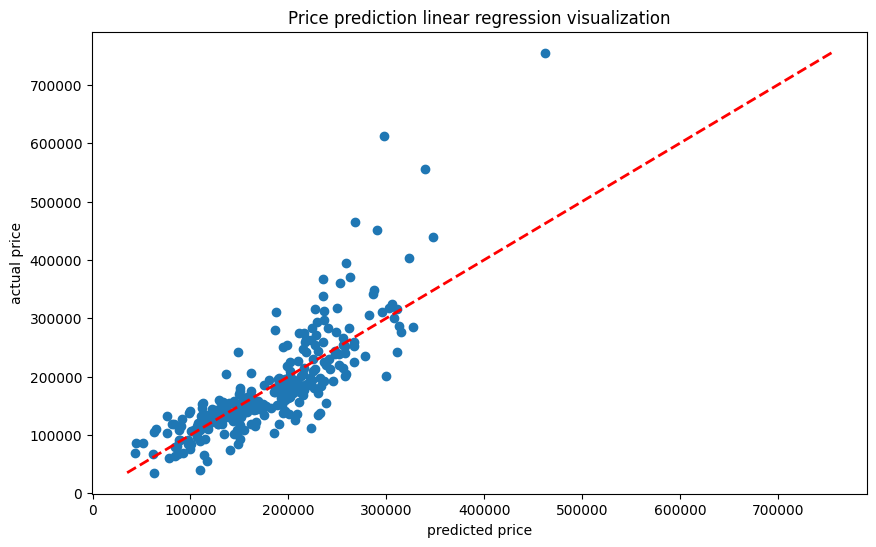

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred_linear.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('predicted price')
plt.ylabel('actual price')
plt.title("Price prediction linear regression visualization")
plt.show()

# Comparison of methods

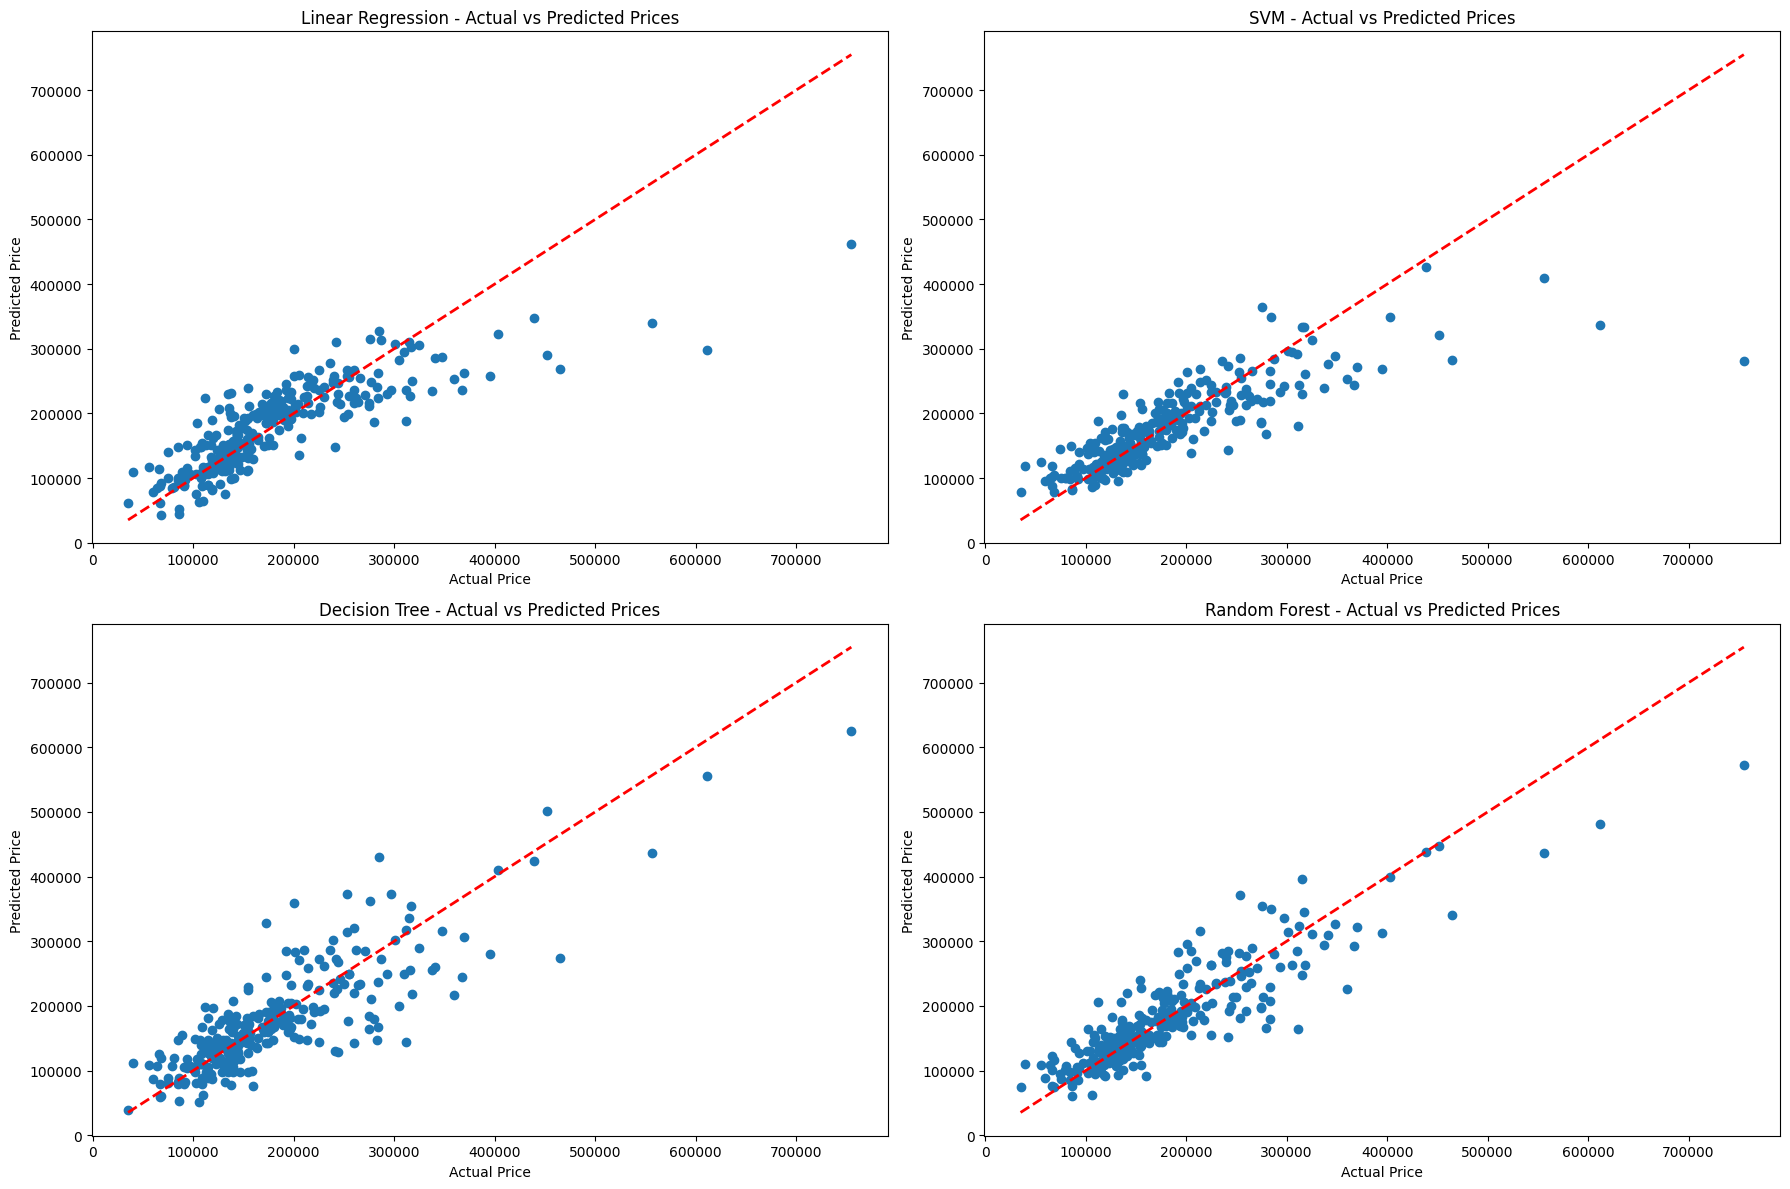

               Model       MSE
0  Linear Regression  0.418398
1                SVM  0.417714
2      Decision Tree  0.378208
3      Random Forest  0.268966


In [ ]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()  # Flatten the 2x2 array of axes to easily iterate over it

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Train, predict, evaluate and plot models
results = []

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)

    # Save the results
    results.append({
        'Model': name,
        'MSE': mse
    })

    # Unscale the predictions and actual values for visualization
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Plotting the results
    ax = axes[i]
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.set_title(f'{name} - Actual vs Predicted Prices')

# Adjust layout
plt.tight_layout()
plt.show()

# Summarize results in a table
results_df = pd.DataFrame(results)
print(results_df)

### Methods discussion

- **Linear Regression**: Linear Regression provided a reasonable baseline but struggled with non-linear relationships, resulting in higher errors.
- **SVM**: SVM showed similar performance to Linear Regression, with no significant improvement, likely due to default parameter settings.
- **Decision Tree**: Decision Tree captured non-linear patterns better, reducing MSE, but still suffered from overfitting.
- **Random Forest**: Random Forest effectively captured complex relationships, producing the lowest MSE and the most accurate predictions.

### Conclusion

Random Forest demonstrated the best overall performance for predicting house prices, making it the preferred method among the evaluated models.

# (Advance assignment) Learning using other features

According to the data analysis we already done in the  [Analysis of housing information](https://https://colab.research.google.com/drive/1bSG5BM8A0O5zUWQoIB1rk1Cjl6eO8acZ?usp=sharing#scrollTo=9mVyy_Wie4dQ) we can use the following features which are relevant to predict the houses prices:

- **OverallQual**: Overall material and finish quality
- **GarageCars**: Size of garage in car capacity
- **GarageArea**: Size of garage in square feet
- **TotalBsmtSF**: Total square feet of basement area
- **1stFlrSF**: First Floor square feet

Others features are relevants too, according to ou previous analysis, and we can even combine the **GarageCars** and **GarageArea** in one feature but we will just use them and make the analysis here.

In [ ]:
# Selecting the relevant features (new features included)
features = data[['GrLivArea', 'YearBuilt', 'OverallQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']]
target = data['SalePrice']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Checking for missing values
print(features.isnull().sum())

# If there are missing values, we'll fill them with the median of the column
features = features.fillna(features.median())

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

GrLivArea      0
YearBuilt      0
OverallQual    0
GarageCars     0
GarageArea     0
TotalBsmtSF    0
1stFlrSF       0
dtype: int64


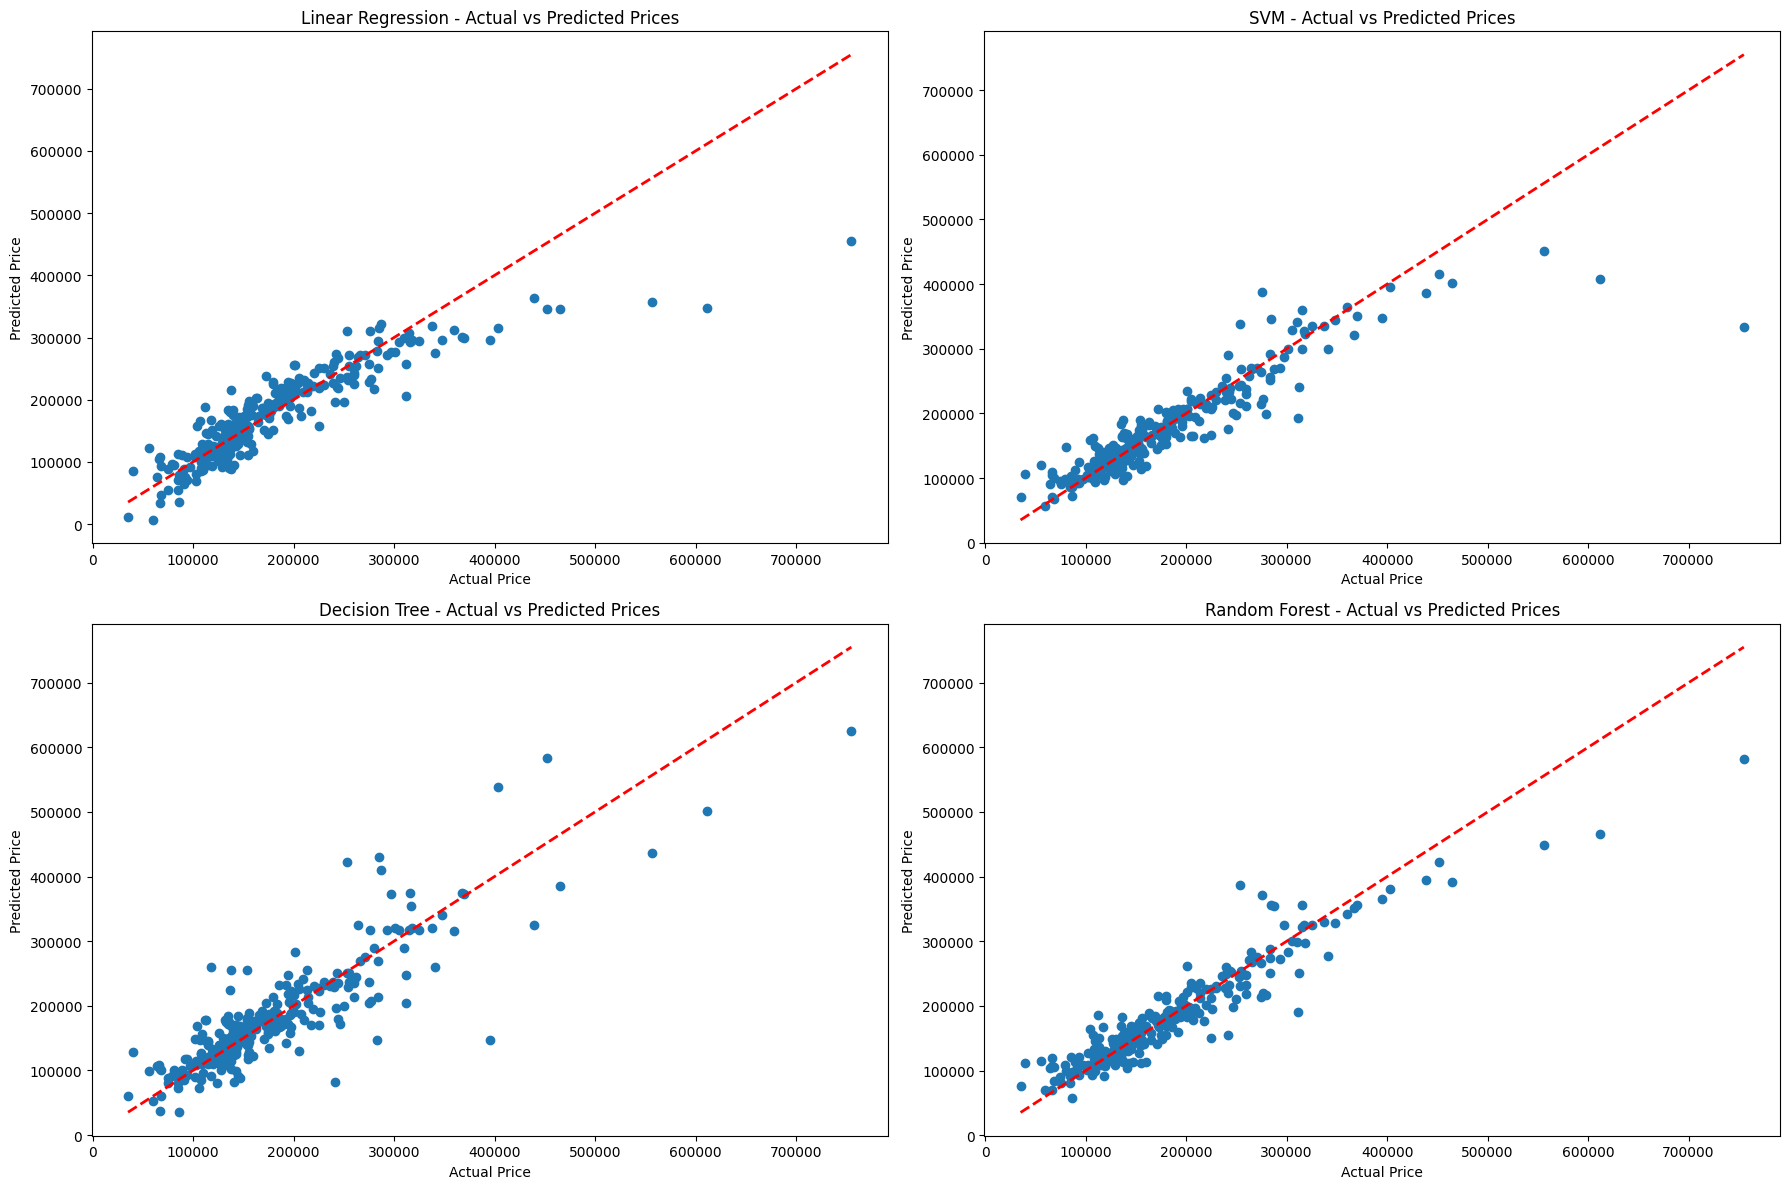

               Model       MSE
0  Linear Regression  0.263052
1                SVM  0.236234
2      Decision Tree  0.312126
3      Random Forest  0.151059


In [ ]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()  # Flatten the 2x2 array of axes to easily iterate over it

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Train, predict, evaluate and plot models
results = []

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)

    # Save the results
    results.append({
        'Model': name,
        'MSE': mse
    })

    # Unscale the predictions and actual values for visualization
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Plotting the results
    ax = axes[i]
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.set_title(f'{name} - Actual vs Predicted Prices')

# Adjust layout
plt.tight_layout()
plt.show()

# Summarize results in a table
results_df = pd.DataFrame(results)
print(results_df)

### Discussion

- **Linear Regression**: With the additional features, Linear Regression significantly improved its performance, reducing the MSE from 0.42 to 0.263, indicating better capture of the relationship between features and house prices.
- **SVM**: SVM also showed improved performance with the new features, lowering its MSE to 0.236, suggesting that SVM benefits from the richer feature set but still has limitations in capturing complex relationships.
- **Decision Tree**: Decision Tree's performance worsened slightly (MSE increased to 0.312), likely due to overfitting on the new feature set, which is a common issue with decision trees when not tuned properly.
- **Random Forest**: Random Forest again outperformed the other models, achieving the lowest MSE of 0.151. The ensemble nature of Random Forest allowed it to better generalize and capture complex patterns in the data.

### Visualizations and Insights

The scatter plots show that the predictions have become tighter around the actual values for most models, especially for Linear Regression, SVM, and Random Forest.
However, they still suffering of outliers. The visual improvement indicates better generalization and accuracy due to the additional features.

### Conclusion

Adding more relevant features improved the performance of Linear Regression and SVM significantly, while the Decision Tree suffered from overfitting. Random Forest continued to be the best performer, highlighting its robustness and ability to generalize well with more complex and numerous features. This analysis underscores the importance of feature selection in improving model accuracy and the strength of ensemble methods like Random Forest in handling complex datasets.